In [1]:
import os
import pandas as pd

In [3]:
df = pd.read_csv('../results/cut_segments_pulp_fiction.csv')
df.head()

,Unnamed: 0,speaker,id,duration,text,seg,start,end,start_tt,end_tt,input_path
0,0,Pumpkin,1,4,Forget it . It 's too risky . I 'm through doi...,"00:00:26,950 --> 00:00:30,878","00:00:26,950","00:00:30,878",26.950,30.878,cut_preprocessed/audio_track_pulp_fiction_eng_...
1,1,Honey Bunny,2,3,You always say that . The same thing every time .,"00:00:30,946 --> 00:00:34,263","00:00:30,946","00:00:34,263",30.946,34.263,cut_preprocessed/audio_track_pulp_fiction_eng_...
2,2,Honey Bunny,3,2,"`` I 'm through , never again , too dangerous ...","00:00:34,260 --> 00:00:36,254","00:00:34,260","00:00:36,254",34.260,36.254,cut_preprocessed/audio_track_pulp_fiction_eng_...
3,3,Pumpkin,4,2,I know that 's what I always say . I 'm always...,"00:00:36,253 --> 00:00:38,716","00:00:36,253","00:00:38,716",36.253,38.716,cut_preprocessed/audio_track_pulp_fiction_eng_...
4,4,Honey Bunny,5,3,You forget about it in a day or two .,"00:00:38,715 --> 00:00:42,043","00:00:38,715","00:00:42,043",38.715,42.043,cut_preprocessed/audio_track_pulp_fiction_eng_...


In [4]:
import logging
from vanpy.utils.utils import load_config

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s:%(name)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

config = load_config('configs/pulp_fiction_pipeline.yaml')

In [5]:
from vanpy.core.Pipeline import Pipeline
pipeline = Pipeline(
        ['silero_vad', 'speechbrain_embedding', 'openai_whisper_stt', 'speech_brain_iemocap_emotion',
         'vanpy_voxceleb_gender', 'vanpy_voxceleb_age', 'vanpy_voxceleb_height', 'vanpy_ravdess_emotion', 'wav2vec2adv', 'yamnet_classifier', 'cosine_distance_diarization'], config=config)

2023-07-24 16:06:54 - INFO:PreprocessPipeline - Created Preprocessing Pipeline with 1 components
2023-07-24 16:07:40 - WARNING:speechbrain.utils.torch_audio_backend - The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
2023-07-24 16:07:42 - WARNING:speechbrain.utils.torch_audio_backend - The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
2023-07-24 16:07:42 - INFO:FeatureExtractionPipeline - Created Feature Extraction Pipeline with 1 components
2023-07-24 16:09:04 - INFO:ClassificationPipeline - Created Classification Pipeline with 9 components


In [4]:
processed_payload = pipeline.process()

2023-07-09 16:44:26 - INFO:PreprocessPipeline - Processing with file_mapper
2023-07-09 16:44:26 - INFO:preprocessing - file_mapper - Called Saved payload ('file_mapper', False), intermediate False
2023-07-09 16:44:26 - INFO:PreprocessPipeline - Processing with sepformer_se
2023-07-09 16:44:27 - WARNING:speechbrain.utils.torch_audio_backend - The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
2023-07-09 16:44:28 - WARNING:speechbrain.utils.torch_audio_backend - The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
2023-07-09 16:44:28 - INFO:speechbrain.pretrained.fetching - Fetch hyperparams.yaml: Using existing file/symlink in pretrained_models\sepformer-wham16k-enhancement\hyperparams.yaml.
2023-07-09 16:44:28 - INFO:speechbrain.pretrained.fetching - Fetch custom.py: Delegating to Huggingface hub, source speechbrain/sepformer-wham16k-enhancement.
2023-07-09 16:44:28 - WARNING:speechbrain.utils

In [80]:
features_and_annotations_df = pd.merge(left=processed_payload.get_classification_df().dropna(), right=processed_payload.df[['silero_vad_processed_path', 'speaker', 'id', 'duration', 'text', 'start_tt', 'end_tt']].dropna(), on='silero_vad_processed_path', how='inner')

In [81]:
from collections import Counter

ids_counter = Counter(features_and_annotations_df['id'])  # remove more than one speaker in a segment
ids_to_remove = [k for k, v in ids_counter.items() if v > 1]
features_and_annotations_df = features_and_annotations_df[~features_and_annotations_df['id'].isin(ids_to_remove)]

In [7]:
# features_and_annotations_df.to_csv('results/pulp_fiction/classification_pulp_fiction.csv')
features_and_annotations_df = pd.read_csv('results/pulp_fiction/classification_pulp_fiction.csv')
features_and_annotations_df = features_and_annotations_df[~features_and_annotations_df['text'].str.startswith('-LSB-')]
features_and_annotations_df = features_and_annotations_df[features_and_annotations_df['end_tt'] - features_and_annotations_df['start_tt'] > 1]

In [6]:
film_final_shooting_date = '30.11.1993'
actors_df = pd.read_csv('data/Pulp_Fiction_Actors.tsv', sep='\t')
actors_df['screening_age'] = actors_df['birth_date'].apply(lambda x: (pd.to_datetime(film_final_shooting_date) - pd.to_datetime(x)).days / 365)

In [8]:
actors_df

,actor,character,gender,birth_date,height,screening_age
0,Tim Roth,Pumpkin,M,14.05.1961,1.73,32.569863
1,Amanda Plummer,Honey Bunny,F,23.03.1957,1.63,36.715068
2,John Travolta,Vincent Vega,M,14.02.1954,1.88,39.819178
3,Samuel L. Jackson,Jules Winnfield,M,21.12.1948,1.89,44.972603
4,Phil LaMarr,Marvin,M,24.01.1967,1.77,26.868493
5,Frank Whaley,Brett,M,20.07.1963,1.75,30.386301
6,Burr Steers,Roger,M,08.10.1965,NaN,28.326027
7,Bruce Willis,Butch Coolidge,M,19.03.1955,1.82,38.728767
8,Ving Rhames,Marsellus Wallace,M,12.05.1959,1.80,34.010959
9,Paul Calderon,Paul,M,07.07.1959,NaN,34.424658


In [6]:
features_and_annotations_df

,Unnamed: 0,silero_vad_processed_path,whisper_transcript,whisper_language,speech_brain_iemocap_emotion,vanpy_voxceleb_gender_classification,vanpy_voxceleb_age_estimation,vanpy_voxceleb_height_estimation,vanpy_ravdess_emotion,arousal,dominance,valence,yamnet_classification,diarization_classification,speaker,id,duration,text,start_tt,end_tt
0,0,silero_vad_preprocessed/audio_track_pulp_ficti...,to get it. It's too risky.,en,neu,male,30.882626,181.85678,fearful,0.568810,0.589491,0.381561,Speech,SPEAKER_0,Pumpkin,1,4,Forget it . It 's too risky . I 'm through doi...,26.950,30.878
1,1,silero_vad_preprocessed/audio_track_pulp_ficti...,You'll say that the same thing every time. I'...,en,sad,female,49.481808,158.77185,surprised,0.543270,0.575906,0.491519,Speech,SPEAKER_1,Honey Bunny,2,3,You always say that . The same thing every time .,30.946,34.263
2,2,silero_vad_preprocessed/audio_track_pulp_ficti...,never again too dangerous.,en,neu,female,37.741985,167.69025,surprised,0.360790,0.448852,0.353106,Speech,SPEAKER_1,Honey Bunny,3,2,"`` I 'm through , never again , too dangerous ...",34.260,36.254
3,3,silero_vad_preprocessed/audio_track_pulp_ficti...,And that's why I always say I'm always right ...,en,neu,male,29.821240,177.66922,neutral/calm,0.536591,0.576020,0.654322,Speech,SPEAKER_2,Pumpkin,4,2,I know that 's what I always say . I 'm always...,36.253,38.716
4,6,silero_vad_preprocessed/audio_track_pulp_ficti...,Copyright 2004.,en,sad,male,33.517670,178.54314,fearful,0.506780,0.544164,0.662310,Speech,SPEAKER_2,Pumpkin,6,2,The days of me remembering have just begun .,42.040,44.119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,2010,silero_vad_preprocessed/audio_track_pulp_ficti...,week.,en,ang,male,46.128830,186.65475,sad,0.311069,0.447930,0.343298,Speech,SPEAKER_43,Jules Winnfield,2184,1,you 're the weak ...,8530.376,8532.230
1232,2011,silero_vad_preprocessed/audio_track_pulp_ficti...,Ageness legacies at будтоcal Rio de Godan Eve...,en,neu,male,43.806385,190.85503,sad,0.287299,0.426815,0.514851,Speech,SPEAKER_40,Jules Winnfield,2185,3,and I 'm the tyranny of evil men .,8533.574,8536.835
1233,2012,silero_vad_preprocessed/audio_track_pulp_ficti...,Easter In prevent pie hi,en,neu,male,52.639133,199.86975,sad,0.096224,0.255936,0.306560,Speech,SPEAKER_2,Jules Winnfield,2186,1,"But I 'm tryin ' , Ringo .",8538.178,8540.033
1234,2013,silero_vad_preprocessed/audio_track_pulp_ficti...,real.,en,neu,male,61.613770,188.54291,neutral/calm,0.392980,0.472016,0.547569,Speech,SPEAKER_1,Jules Winnfield,2187,2,I 'm tryin ' real hard ...,8541.247,8544.062


In [9]:
features_df = pd.read_csv('results/pulp_fiction/final_feature_classification_df.csv')
features_df = features_df[features_df['id'].isin(features_and_annotations_df['id'])]

C:\ProgramData\miniconda3\envs\vanpy-gpu-3.9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\miniconda3\envs\vanpy-gpu-3.9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


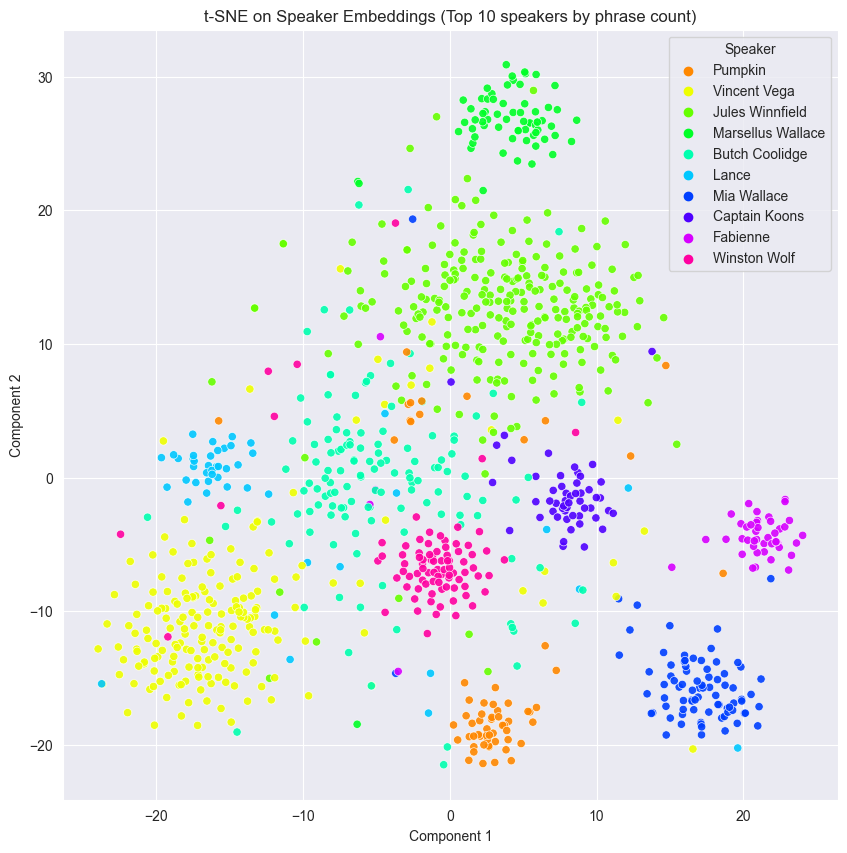

In [10]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Select the necessary columns
feature_cols = [str(i) + '_speechbrain_embedding' for i in range(192)]
features = features_df[feature_cols].dropna()

# Get the top 10 speakers by phrase count
top_speakers = features_df['speaker'].value_counts().nlargest(10).index

# Filter the features and speaker data to include only the top speakers
features_top_speakers = features[features_df['speaker'].isin(top_speakers)]
speakers_top_speakers = features_df[features_df['speaker'].isin(top_speakers)]['speaker']

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the features of the top speakers
tsne_results = tsne.fit_transform(features_top_speakers)

# Create a DataFrame to plot
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Component 1', 'Component 2'])
tsne_df['Speaker'] = speakers_top_speakers.reset_index(drop=True)

# Use seaborn to visualize the result
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="Component 1", y="Component 2",
    hue="Speaker",
    palette=sns.color_palette("hsv", len(tsne_df['Speaker'].unique())),
    data=tsne_df,
    legend="full",
    alpha=0.9
)

plt.title('t-SNE on Speaker Embeddings (Top 10 speakers by phrase count)')
plt.show()

In [11]:
features_and_annotations_df['gender_value'] = features_and_annotations_df['vanpy_voxceleb_gender_classification'].apply(lambda x: 1 if x == 'male' else 0)

In [12]:
mean_estimation_df = features_and_annotations_df[['speaker', 'gender_value', 'vanpy_voxceleb_age_estimation', 'vanpy_voxceleb_height_estimation', 'arousal', 'dominance', 'valence']].groupby('speaker').mean()

In [13]:
mean_estimation_df

,gender_value,vanpy_voxceleb_age_estimation,vanpy_voxceleb_height_estimation,arousal,dominance,valence
speaker,,,,,,
Brett,1.000000,37.986972,177.468991,0.542076,0.568118,0.469214
Buddy Holly,0.750000,39.126655,182.285560,0.511001,0.530898,0.583042
Butch Coolidge,0.977099,47.402189,183.628694,0.530984,0.544476,0.452060
Butch's Mother,0.000000,44.103842,171.003410,0.481765,0.543033,0.545290
Captain Koons,1.000000,50.586125,184.762862,0.407695,0.486726,0.457898
Ed Sullivan,0.888889,55.542465,187.829537,0.677836,0.654026,0.507951
Esmarelda Villalobos,0.062500,45.323785,182.951362,0.433721,0.437948,0.456534
Fabienne,0.063830,43.751620,171.757504,0.423398,0.463539,0.471451
Floyd Wilson,1.000000,54.058636,171.169820,0.618965,0.527662,0.538359


In [14]:
merged_df = pd.merge(left=actors_df, right=mean_estimation_df, left_on='character', right_on='speaker', how='inner')
merged_df['height'] = merged_df['height'].apply(lambda x: x * 100)
merged_df['gender_confidence'] = merged_df.apply(lambda x: x['gender_value'] if x['gender'] == "M" else 1 - x['gender_value'], axis=1)

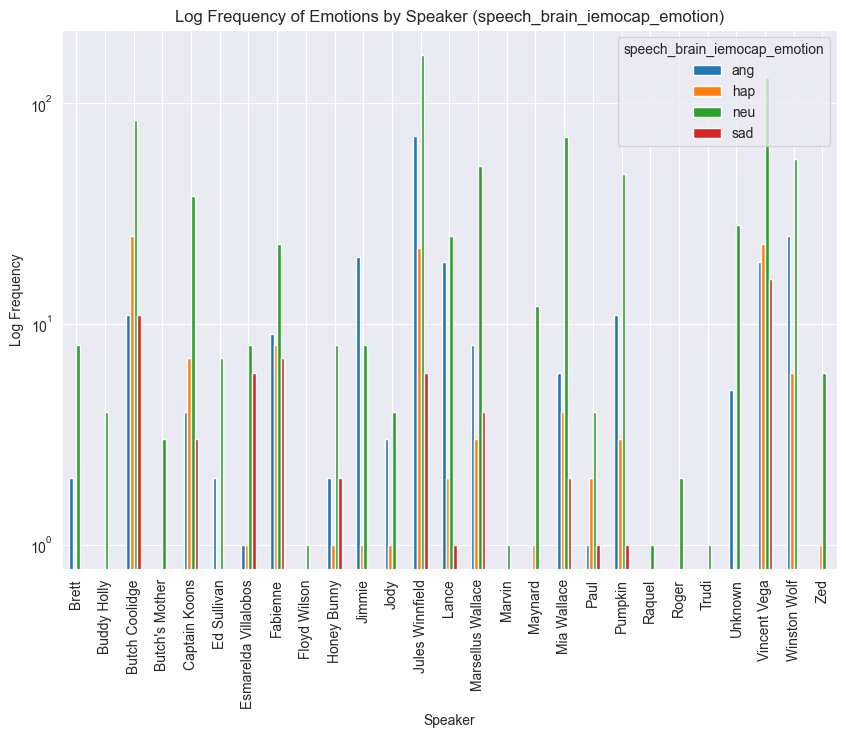

In [15]:
from matplotlib import pyplot as plt

# Create a cross-tabulation of 'speaker' and 'vanpy_ravdess_emotion'
emotion_by_speaker = pd.crosstab(features_and_annotations_df['speaker'], features_and_annotations_df['speech_brain_iemocap_emotion'])

# Plot the grouped bar chart
emotion_by_speaker.plot(kind='bar', stacked=False, figsize=(10, 7))

# Add labels and title
plt.xlabel('Speaker')
plt.ylabel('Log Frequency')
plt.title('Log Frequency of Emotions by Speaker (speech_brain_iemocap_emotion)')

# Set y-axis to log scale
plt.yscale('log')

plt.show()

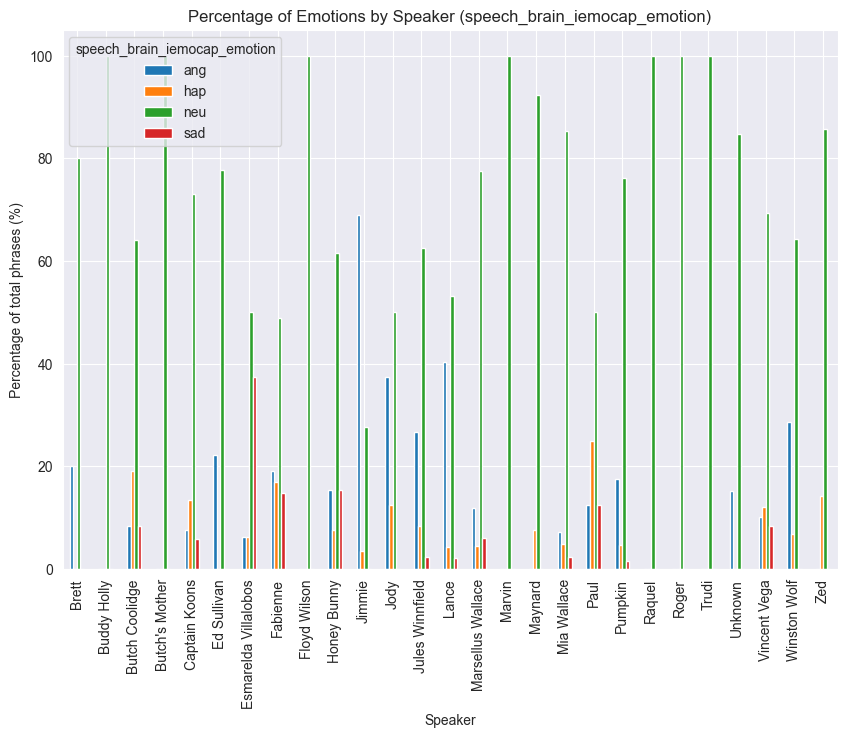

In [16]:
import numpy as np

# Create a cross-tabulation of 'speaker' and 'vanpy_ravdess_emotion'
emotion_by_speaker = pd.crosstab(features_and_annotations_df['speaker'], features_and_annotations_df['speech_brain_iemocap_emotion'])

# Normalize each row (speaker) to sum to 1 (proportion of total phrases)
emotion_by_speaker = emotion_by_speaker.div(emotion_by_speaker.sum(axis=1), axis=0)

# Convert to percentages
emotion_by_speaker = emotion_by_speaker.mul(100)

# Plot the grouped bar chart
emotion_by_speaker.plot(kind='bar', stacked=False, figsize=(10, 7))

# Add labels and title
plt.xlabel('Speaker')
plt.ylabel('Percentage of total phrases (%)')
plt.title('Percentage of Emotions by Speaker (speech_brain_iemocap_emotion)')

plt.show()

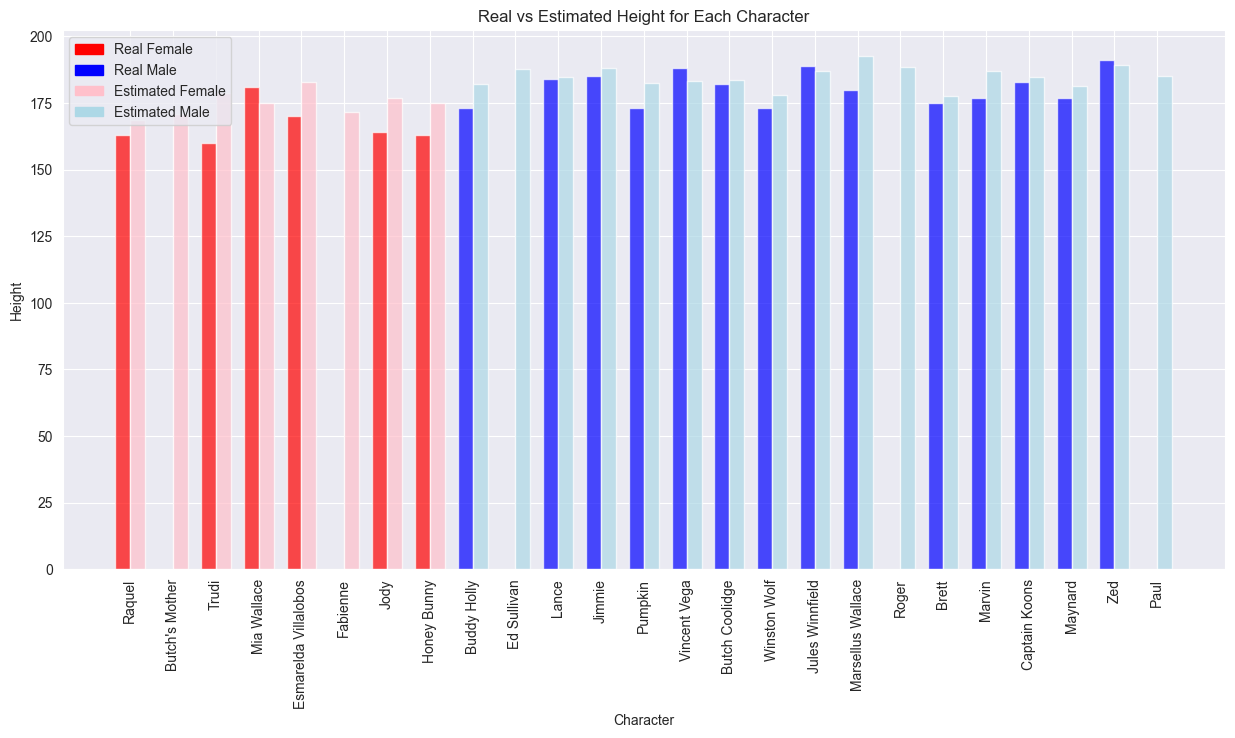

In [17]:
# plot real height distribution vs vanpy height estimation distribution grouped by gender
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Sort by gender_value
sorted_df = merged_df.sort_values('gender_value')

# Set colors based on gender
colors = ['red' if g == 'F' else 'blue' for g in sorted_df['gender']]
light_colors = ['pink' if g == 'F' else 'lightblue' for g in sorted_df['gender']]  # light red and light blue

# Create an index for each character
ind = np.arange(len(sorted_df))

# Create the bar plot
plt.figure(figsize=(15, 7))  # Adjust size as needed
width = 0.35  # width of the bars

# Plot the real heights
plt.bar(ind - width/2, sorted_df['height'], width, color=colors, alpha=0.7, label='Real')

# Plot the estimated heights
plt.bar(ind + width/2, sorted_df['vanpy_voxceleb_height_estimation'], width, color=light_colors, alpha=0.7, label='Estimated')

# Label axes and title
plt.xlabel('Character')
plt.ylabel('Height')
plt.title('Real vs Estimated Height for Each Character')

# Rotate x labels if needed and set them to character names
plt.xticks(ind, sorted_df['character'], rotation=90)

# Create legend
red_patch = mpatches.Patch(color='red', label='Real Female')
blue_patch = mpatches.Patch(color='blue', label='Real Male')
light_red_patch = mpatches.Patch(color='pink', label='Estimated Female')
light_blue_patch = mpatches.Patch(color='lightblue', label='Estimated Male')

plt.legend(handles=[red_patch, blue_patch, light_red_patch, light_blue_patch])

# Show the plot
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# For males
male_df = sorted_df[sorted_df['gender'] == 'M'][['height', 'vanpy_voxceleb_height_estimation', 'gender']].dropna()
male_real = male_df['height']
male_estimated = male_df['vanpy_voxceleb_height_estimation']
rmse_male = sqrt(mean_squared_error(male_real, male_estimated))
print(f"RMSE for males: {rmse_male}")

# For females
female_df = sorted_df[sorted_df['gender'] == 'F'][['height', 'vanpy_voxceleb_height_estimation', 'gender']].dropna()
female_real = female_df['height']
female_estimated = female_df['vanpy_voxceleb_height_estimation']
rmse_female = sqrt(mean_squared_error(female_real, female_estimated))
print(f"RMSE for females: {rmse_female}")

RMSE for males: 6.199091163290334
RMSE for females: 12.170291708350856


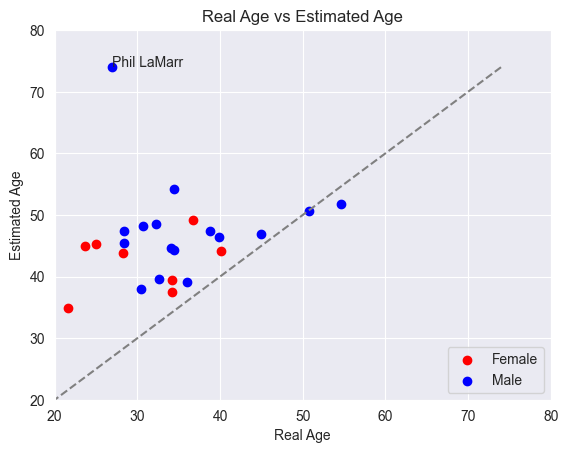

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming merged_df is your dataframe

# Separate the data for males and females
df_male = merged_df[merged_df['gender'] == 'M'].copy()
df_female = merged_df[merged_df['gender'] == 'F'].copy()

# Sort the dataframes
df_male.sort_values('screening_age', inplace=True)
df_female.sort_values('screening_age', inplace=True)

# Define outliers. Adjust this according to your definition of an "outlier"
outlier_threshold = df_male['vanpy_voxceleb_age_estimation'].quantile(0.95)

# Plot the data
plt.scatter(df_female['screening_age'], df_female['vanpy_voxceleb_age_estimation'], color='red', label='Female')
plt.scatter(df_male['screening_age'], df_male['vanpy_voxceleb_age_estimation'], color='blue', label='Male')

# Add labels to outliers
for i, row in df_male.iterrows():
    if row['vanpy_voxceleb_age_estimation'] > outlier_threshold:
        plt.text(row['screening_age'], row['vanpy_voxceleb_age_estimation'], row['actor'])

# Add a reference line
max_age = max(merged_df['screening_age'].max(), merged_df['vanpy_voxceleb_age_estimation'].max())
plt.plot([0, max_age], [0, max_age], color='gray', linestyle='--')

# Label the axes and title
plt.xlabel('Real Age')
plt.ylabel('Estimated Age')
plt.title('Real Age vs Estimated Age')

# Limit x and y ticks
plt.xlim(20, 80)
plt.ylim(20, 80)

# Show the legend
plt.legend()

# Show the plot
plt.show()

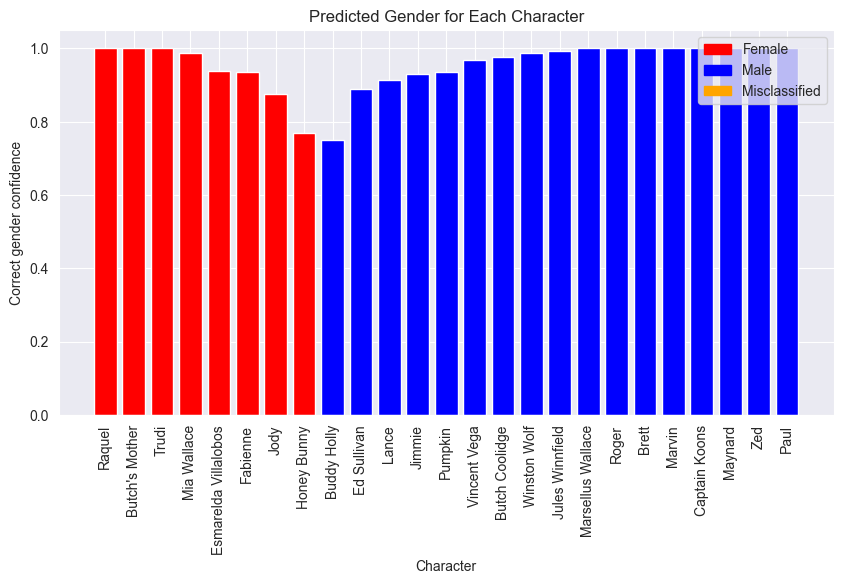

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Sort by gender_value
sorted_df = merged_df.sort_values('gender_value')

# Define a function to classify based on the threshold and real gender
def classify_gender(row):
    if row['gender_value'] >= 0.5 and row['gender'] == 'M':  # correctly classified as male
        return 'blue'
    elif row['gender_value'] < 0.5 and row['gender'] == 'F':  # correctly classified as female
        return 'red'
    else:  # misclassified
        return 'orange'

# Apply the function to create a list of colors
colors = sorted_df.apply(classify_gender, axis=1)

# Create the bar plot
plt.figure(figsize=(10, 5))  # Adjust size as needed
plt.bar(sorted_df['character'], sorted_df['gender_confidence'], color=colors)

# Label axes and title
plt.xlabel('Character')
plt.ylabel('Correct gender confidence')
plt.title('Predicted Gender for Each Character')

# Rotate x labels if needed
plt.xticks(rotation=90)

# Create legend
blue_patch = mpatches.Patch(color='blue', label='Male')
red_patch = mpatches.Patch(color='red', label='Female')
orange_patch = mpatches.Patch(color='orange', label='Misclassified')
plt.legend(handles=[red_patch, blue_patch, orange_patch])

# Show the plot
plt.show()

In [21]:
sorted_df['gender_confidence'].mean()

0.9541337026973014

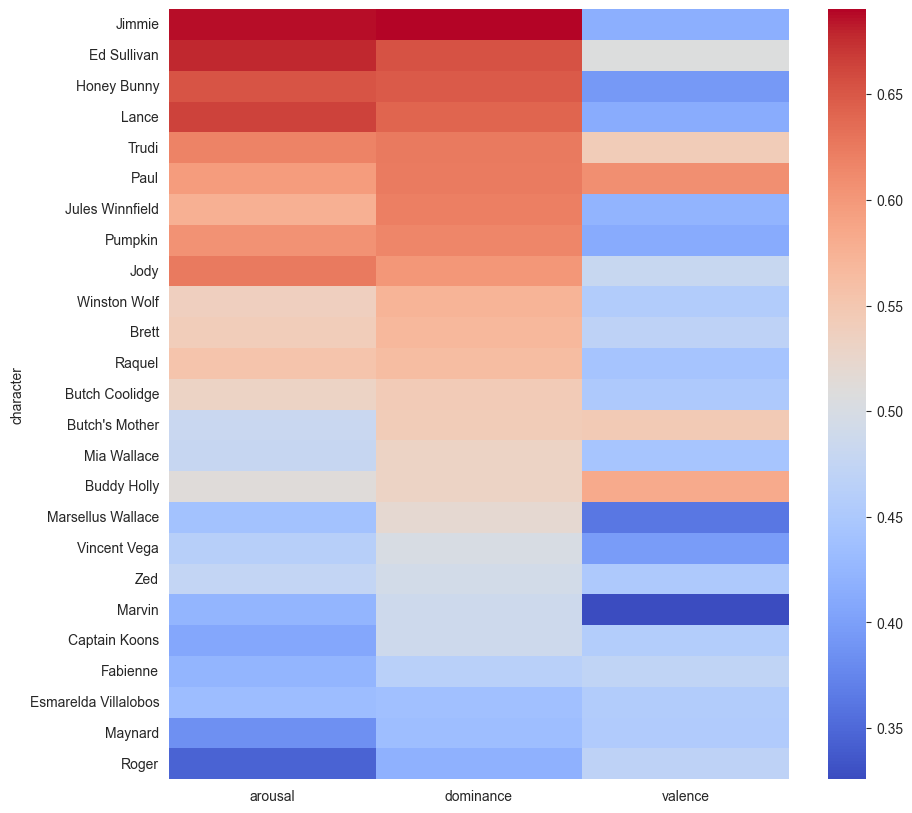

In [22]:
import seaborn as sns

# Sort in ascending order
sorted_df = merged_df.sort_values(by=['dominance', 'valence', 'arousal'], ascending=[False, False, False])
# Select relevant columns and set character as index
heatmap_data = sorted_df.set_index('character')[['arousal', 'dominance', 'valence']]

# Create the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, cmap='coolwarm')

plt.show()